In [54]:
import numpy as np
import pandas as pd
import pickle
from IPython.display import Image
from IPython.display import Image, display
import random
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
import sys
sys.path.append('../ConceptBottleneck/src/')

from CUB.dataset import load_data

## Exam the resilt and explanations of CBM

### 1. Load files

In [61]:
data_dir = '..\\..\\CBM_results\\'
model = 'Joint0.01Model_ori\\'
output_dir = data_dir+model+'outputs\\'

In [62]:
gt_class_labels = np.load(output_dir+'all_class_labels_model0.npy')
pred_class_logits = np.load(output_dir+'all_class_logits_model0.npy')

gt_attr_labels = np.load(output_dir+'all_attr_labels_model0.npy')
pred_attr_outputs = np.load(output_dir+'all_attr_outputs_model0.npy')
pred_attr_outputs_sigmoid = np.load(output_dir+'all_attr_outputs_sigmoid_model0.npy')

# gt_topk_class_labels=np.load(output_dir+'topk_class_labels_model0.npy')
pred_topk_class_outputs=np.load(output_dir+'topk_class_outputs_model0.npy')


print('class_labels: {}'.format(gt_class_labels.shape))
print('class_logits: {}'.format(pred_class_logits.shape))
print('attr_labels: {}'.format(gt_attr_labels.shape))
print('attr_outputs: {}'.format(pred_attr_outputs.shape))
print('attr_outputs_sigmoid: {}'.format(pred_attr_outputs_sigmoid.shape))
# print('topk_labels: {}'.format(gt_topk_class_labels.shape))
print('topk_outputs: {}'.format(pred_topk_class_outputs.shape))

class_labels: (5794,)
class_logits: (5794, 200)
attr_labels: (648928,)
attr_outputs: (648928,)
attr_outputs_sigmoid: (648928,)
topk_outputs: (5794, 5)


In [63]:
# reshape
gt_attr_labels = gt_attr_labels.reshape(len(gt_class_labels),-1)
pred_attr_outputs = pred_attr_outputs.reshape(len(gt_class_labels),-1)
pred_attr_outputs_sigmoid = pred_attr_outputs_sigmoid.reshape(len(gt_class_labels),-1)
gt_attr_labels.shape

(5794, 112)

In [64]:
gt_attr_labels[0,:]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

### 2. Load images (test set)

In [24]:
dataset_dir = '..\\ConceptBottleneck\\CUB_processed\\class_attr_data_10\\'
pkl_file_path = dataset_dir+'test.pkl'
pkl_file = open(pkl_file_path, 'rb')
test_image_pkl = pickle.load(pkl_file)

print(len(test_image_pkl))
print(test_image_pkl[0].keys())

5794
dict_keys(['id', 'img_path', 'class_label', 'attribute_label', 'attribute_certainty'])


Use dataloader to load the images:

In [35]:
loader = load_data([dataset_dir+'test.pkl'], use_attr=True, no_img=False, 
                   batch_size=64, image_dir='..\\ConceptBottleneck\\CUB_200_2011\\images\\')

In [51]:
test_images_loader=[]
test_labels_loader=[]
test_attr_labels_loader=[]

for idx,data in enumerate(tqdm(loader)):
    inputs, labels, attr_labels = data
    test_images_loader.extend([inputs[i] for i in range(len(inputs))])
    test_labels_loader.extend([labels[i] for i in range(len(labels))])
    test_attr_labels_loader.extend([attr_labels[i] for i in range(len(attr_labels))])
    

100%|██████████████████████████████████████████████████████████████████████████████████| 91/91 [00:32<00:00,  2.81it/s]


In [47]:
len(test_images_loader)

5794

### 3. Get attributes list and class list

In [21]:
chose_attr=[1, 4, 6, 7, 10, 14, 15, 20, 21, 23, 25, 29, 30, 35, 36, 38, 40, 44, 45, 50, 51, 53, 54, 56, 57, 59, 63, 64, 69, 70, 72, 75, 80, 84, 90, 91, \
    93, 99, 101, 106, 110, 111, 116, 117, 119, 125, 126, 131, 132, 134, 145, 149, 151, 152, 153, 157, 158, 163, 164, 168, 172, 178, 179, 181, \
    183, 187, 188, 193, 194, 196, 198, 202, 203, 208, 209, 211, 212, 213, 218, 220, 221, 225, 235, 236, 238, 239, 240, 242, 243, 244, 249, 253, \
    254, 259, 260, 262, 268, 274, 277, 283, 289, 292, 293, 294, 298, 299, 304, 305, 308, 309, 310, 311]
attr_file = '..\\ConceptBottleneck\\CUB_200_2011\\attributes\\attributes.txt'
attributes=[]
with open(attr_file) as f:
    lines = f.readlines()
    for line in lines:
        info = line.split(' ')
        attributes.append(info[1][:-1])
attributes = [attributes[i] for i in chose_attr]
print('the first 10 attributes used in CBM:\n{}'.format(attributes[:10]))

the first 10 attributes used in CBM:
['has_bill_shape::dagger', 'has_bill_shape::hooked_seabird', 'has_bill_shape::all-purpose', 'has_bill_shape::cone', 'has_wing_color::brown', 'has_wing_color::grey', 'has_wing_color::yellow', 'has_wing_color::black', 'has_wing_color::white', 'has_wing_color::buff']


In [22]:
class_file = '..\\ConceptBottleneck\\CUB_200_2011\\classes.txt'
classes = []
with open(class_file) as f:
    lines = f.readlines()
    for line in lines:
        info = line.split(' ')[1].split('.')[1][:-2]
        classes.append(info)
print('the first 10 classes used in CBM:\n{}'.format(classes[:10]))

the first 10 classes used in CBM:
['Black_footed_Albatros', 'Laysan_Albatros', 'Sooty_Albatros', 'Groove_billed_An', 'Crested_Aukle', 'Least_Aukle', 'Parakeet_Aukle', 'Rhinoceros_Aukle', 'Brewer_Blackbir', 'Red_winged_Blackbir']


### 4. Test on the 10 images (the first image in first 10 categiries)

In [26]:
num=10
indexes = []
target_cat = 0
i = 0
while len(indexes) != num:
    if test_image[i]['class_label']==target_cat:
        print('add {}'.format(i))
        indexes.append(i)
        target_cat+=1
    i+=1

add 0
add 30
add 60
add 88
add 118
add 132
add 143
add 166
add 184
add 213


In [121]:
def show(img):
    npimg = img.permute(1,2,0).numpy()
    npimg = (npimg+0.25)*2
#     plt.imshow((npim*255).astype('uint8'), interpolation='nearest')
    plt.imshow(npimg)
    plt.axis('off')
    plt.show()

------


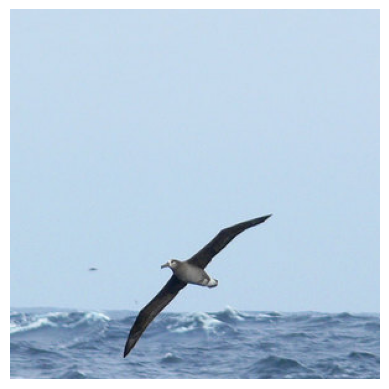

gt-class_label:		0-Black_footed_Albatros
pred-class_label, top1:	2-Sooty_Albatros
pred-class_label, top5:	['2-Sooty_Albatros', '99-Brown_Pelica', '0-Black_footed_Albatros', '22-Brandt_Cormoran', '70-Long_tailed_Jaege']
------
gt-attribute_label: [1, 17, 22, 50, 51, 79, 83, 86, 89]
	1-has_bill_shape::hooked_seabird
	17-has_underparts_color::grey
	22-has_breast_pattern::solid
	50-has_eye_color::black
	51-has_bill_length::about_the_same_as_head
	79-has_size::medium_(9_-_16_in)
	83-has_back_pattern::solid
	86-has_tail_pattern::solid
	89-has_belly_pattern::solid
pred-attribute_label [1, 22, 47, 50, 51, 57, 61, 79, 83, 86, 89, 96, 100, 106, 108]
	1-has_bill_shape::hooked_seabird
	22-has_breast_pattern::solid
	47-has_throat_color::black
	50-has_eye_color::black
	51-has_bill_length::about_the_same_as_head
	57-has_forehead_color::black
	61-has_under_tail_color::black
	79-has_size::medium_(9_-_16_in)
	83-has_back_pattern::solid
	86-has_tail_pattern::solid
	89-has_belly_pattern::solid
	96-has_leg

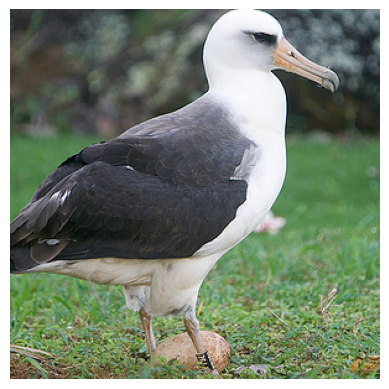

gt-class_label:		1-Laysan_Albatros
pred-class_label, top1:	1-Laysan_Albatros
pred-class_label, top5:	['1-Laysan_Albatros', '65-Western_Gul', '105-Horned_Puffi', '64-Slaty_backed_Gul', '44-Northern_Fulma']
------
gt-attribute_label: [1, 13, 20, 22, 25, 43, 48, 50, 51, 58, 61, 68, 74, 79, 83, 89, 93, 94, 101, 107, 108]
	1-has_bill_shape::hooked_seabird
	13-has_upperparts_color::black
	20-has_underparts_color::white
	22-has_breast_pattern::solid
	25-has_back_color::brown
	43-has_breast_color::white
	48-has_throat_color::white
	50-has_eye_color::black
	51-has_bill_length::about_the_same_as_head
	58-has_forehead_color::white
	61-has_under_tail_color::black
	68-has_nape_color::white
	74-has_belly_color::white
	79-has_size::medium_(9_-_16_in)
	83-has_back_pattern::solid
	89-has_belly_pattern::solid
	93-has_primary_color::black
	94-has_primary_color::white
	101-has_bill_color::buff
	107-has_crown_color::white
	108-has_wing_pattern::solid
pred-attribute_label [1, 13, 20, 22, 25, 43, 48, 50, 51,

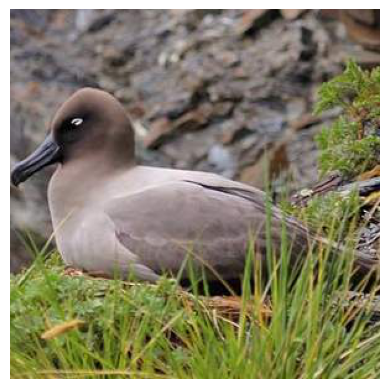

gt-class_label:		2-Sooty_Albatros
pred-class_label, top1:	2-Sooty_Albatros
pred-class_label, top5:	['2-Sooty_Albatros', '70-Long_tailed_Jaege', '0-Black_footed_Albatros', '44-Northern_Fulma', '71-Pomarine_Jaege']
------
gt-attribute_label: [1, 5, 11, 22, 33, 47, 50, 51, 57, 60, 61, 79, 83, 86, 89, 96, 100, 106, 108]
	1-has_bill_shape::hooked_seabird
	5-has_wing_color::grey
	11-has_upperparts_color::grey
	22-has_breast_pattern::solid
	33-has_upper_tail_color::grey
	47-has_throat_color::black
	50-has_eye_color::black
	51-has_bill_length::about_the_same_as_head
	57-has_forehead_color::black
	60-has_under_tail_color::grey
	61-has_under_tail_color::black
	79-has_size::medium_(9_-_16_in)
	83-has_back_pattern::solid
	86-has_tail_pattern::solid
	89-has_belly_pattern::solid
	96-has_leg_color::grey
	100-has_bill_color::black
	106-has_crown_color::black
	108-has_wing_pattern::solid
pred-attribute_label [1, 5, 11, 22, 33, 47, 50, 51, 57, 60, 61, 79, 83, 86, 89, 96, 100, 106, 108]
	1-has_bill_shape

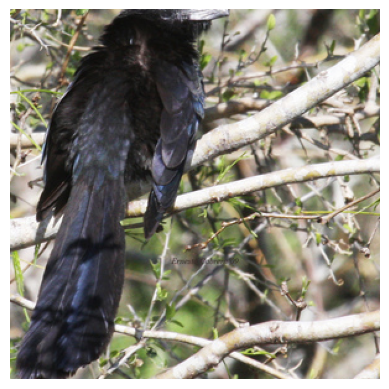

gt-class_label:		3-Groove_billed_An
pred-class_label, top1:	3-Groove_billed_An
pred-class_label, top5:	['3-Groove_billed_An', '29-Fish_Cro', '25-Bronzed_Cowbir', '26-Shiny_Cowbir', '28-American_Cro']
------
gt-attribute_label: [7, 13, 19, 22, 28, 34, 38, 42, 47, 50, 52, 57, 61, 67, 73, 78, 83, 86, 89, 93, 97, 100, 106, 108]
	7-has_wing_color::black
	13-has_upperparts_color::black
	19-has_underparts_color::black
	22-has_breast_pattern::solid
	28-has_back_color::black
	34-has_upper_tail_color::black
	38-has_head_pattern::plain
	42-has_breast_color::black
	47-has_throat_color::black
	50-has_eye_color::black
	52-has_bill_length::shorter_than_head
	57-has_forehead_color::black
	61-has_under_tail_color::black
	67-has_nape_color::black
	73-has_belly_color::black
	78-has_size::small_(5_-_9_in)
	83-has_back_pattern::solid
	86-has_tail_pattern::solid
	89-has_belly_pattern::solid
	93-has_primary_color::black
	97-has_leg_color::black
	100-has_bill_color::black
	106-has_crown_color::black
	108-has_

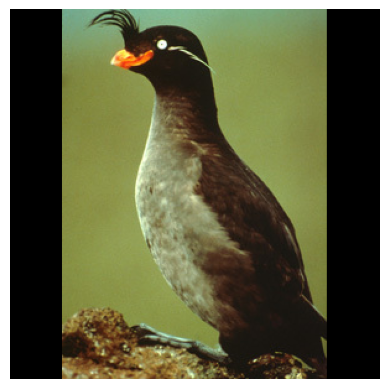

gt-class_label:		4-Crested_Aukle
pred-class_label, top1:	4-Crested_Aukle
pred-class_label, top5:	['4-Crested_Aukle', '6-Parakeet_Aukle', '23-Red_faced_Cormoran', '8-Brewer_Blackbir', '18-Gray_Catbir']
------
gt-attribute_label: [7, 13, 17, 22, 28, 34, 40, 42, 47, 52, 57, 61, 67, 71, 73, 77, 79, 83, 86, 89, 93, 96, 106, 108]
	7-has_wing_color::black
	13-has_upperparts_color::black
	17-has_underparts_color::grey
	22-has_breast_pattern::solid
	28-has_back_color::black
	34-has_upper_tail_color::black
	40-has_breast_color::grey
	42-has_breast_color::black
	47-has_throat_color::black
	52-has_bill_length::shorter_than_head
	57-has_forehead_color::black
	61-has_under_tail_color::black
	67-has_nape_color::black
	71-has_belly_color::grey
	73-has_belly_color::black
	77-has_wing_shape::pointed-wings
	79-has_size::medium_(9_-_16_in)
	83-has_back_pattern::solid
	86-has_tail_pattern::solid
	89-has_belly_pattern::solid
	93-has_primary_color::black
	96-has_leg_color::grey
	106-has_crown_color::black
	1

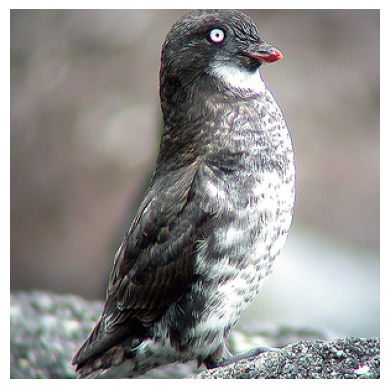

gt-class_label:		5-Least_Aukle
pred-class_label, top1:	5-Least_Aukle
pred-class_label, top5:	['5-Least_Aukle', '4-Crested_Aukle', '6-Parakeet_Aukle', '66-Anna_Hummingbir', '121-Harris_Sparro']
------
gt-attribute_label: [3, 7, 8, 11, 13, 17, 19, 20, 23, 28, 34, 40, 42, 43, 48, 52, 57, 61, 62, 67, 71, 74, 93, 96, 100, 106, 110]
	3-has_bill_shape::cone
	7-has_wing_color::black
	8-has_wing_color::white
	11-has_upperparts_color::grey
	13-has_upperparts_color::black
	17-has_underparts_color::grey
	19-has_underparts_color::black
	20-has_underparts_color::white
	23-has_breast_pattern::striped
	28-has_back_color::black
	34-has_upper_tail_color::black
	40-has_breast_color::grey
	42-has_breast_color::black
	43-has_breast_color::white
	48-has_throat_color::white
	52-has_bill_length::shorter_than_head
	57-has_forehead_color::black
	61-has_under_tail_color::black
	62-has_under_tail_color::white
	67-has_nape_color::black
	71-has_belly_color::grey
	74-has_belly_color::white
	93-has_primary_color::bla

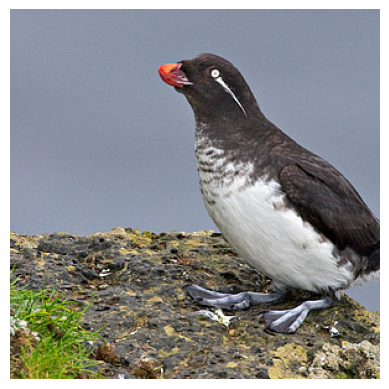

gt-class_label:		6-Parakeet_Aukle
pred-class_label, top1:	6-Parakeet_Aukle
pred-class_label, top5:	['6-Parakeet_Aukle', '105-Horned_Puffi', '88-Hooded_Merganse', '4-Crested_Aukle', '23-Red_faced_Cormoran']
------
gt-attribute_label: [7, 13, 20, 28, 34, 43, 47, 48, 52, 57, 61, 67, 74, 79, 83, 86, 89, 93, 94, 96, 106, 108]
	7-has_wing_color::black
	13-has_upperparts_color::black
	20-has_underparts_color::white
	28-has_back_color::black
	34-has_upper_tail_color::black
	43-has_breast_color::white
	47-has_throat_color::black
	48-has_throat_color::white
	52-has_bill_length::shorter_than_head
	57-has_forehead_color::black
	61-has_under_tail_color::black
	67-has_nape_color::black
	74-has_belly_color::white
	79-has_size::medium_(9_-_16_in)
	83-has_back_pattern::solid
	86-has_tail_pattern::solid
	89-has_belly_pattern::solid
	93-has_primary_color::black
	94-has_primary_color::white
	96-has_leg_color::grey
	106-has_crown_color::black
	108-has_wing_pattern::solid
pred-attribute_label [7, 13, 20, 28

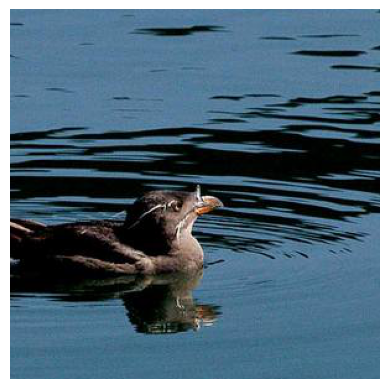

gt-class_label:		7-Rhinoceros_Aukle
pred-class_label, top1:	7-Rhinoceros_Aukle
pred-class_label, top5:	['7-Rhinoceros_Aukle', '57-Pigeon_Guillemo', '105-Horned_Puffi', '4-Crested_Aukle', '24-Pelagic_Cormoran']
------
gt-attribute_label: [7, 13, 17, 22, 28, 34, 40, 42, 45, 47, 50, 52, 57, 61, 67, 79, 81, 83, 86, 89, 93, 98, 106, 108]
	7-has_wing_color::black
	13-has_upperparts_color::black
	17-has_underparts_color::grey
	22-has_breast_pattern::solid
	28-has_back_color::black
	34-has_upper_tail_color::black
	40-has_breast_color::grey
	42-has_breast_color::black
	45-has_throat_color::grey
	47-has_throat_color::black
	50-has_eye_color::black
	52-has_bill_length::shorter_than_head
	57-has_forehead_color::black
	61-has_under_tail_color::black
	67-has_nape_color::black
	79-has_size::medium_(9_-_16_in)
	81-has_shape::duck-like
	83-has_back_pattern::solid
	86-has_tail_pattern::solid
	89-has_belly_pattern::solid
	93-has_primary_color::black
	98-has_leg_color::buff
	106-has_crown_color::black
	10

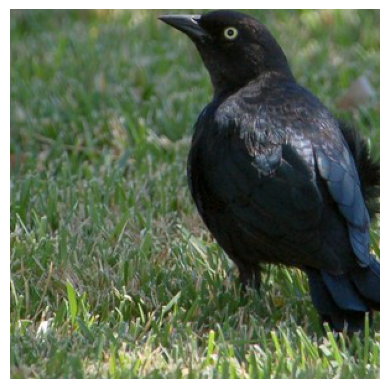

gt-class_label:		8-Brewer_Blackbir
pred-class_label, top1:	8-Brewer_Blackbir
pred-class_label, top5:	['8-Brewer_Blackbir', '28-American_Cro', '26-Shiny_Cowbir', '106-Common_Rave', '9-Red_winged_Blackbir']
------
gt-attribute_label: [2, 7, 13, 19, 22, 28, 34, 42, 47, 50, 52, 57, 61, 67, 73, 76, 78, 83, 86, 89, 93, 97, 100, 106, 108]
	2-has_bill_shape::all-purpose
	7-has_wing_color::black
	13-has_upperparts_color::black
	19-has_underparts_color::black
	22-has_breast_pattern::solid
	28-has_back_color::black
	34-has_upper_tail_color::black
	42-has_breast_color::black
	47-has_throat_color::black
	50-has_eye_color::black
	52-has_bill_length::shorter_than_head
	57-has_forehead_color::black
	61-has_under_tail_color::black
	67-has_nape_color::black
	73-has_belly_color::black
	76-has_wing_shape::rounded-wings
	78-has_size::small_(5_-_9_in)
	83-has_back_pattern::solid
	86-has_tail_pattern::solid
	89-has_belly_pattern::solid
	93-has_primary_color::black
	97-has_leg_color::black
	100-has_bill_color

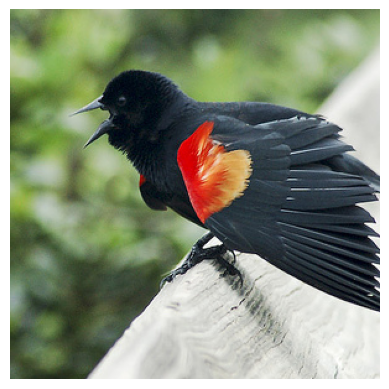

gt-class_label:		9-Red_winged_Blackbir
pred-class_label, top1:	9-Red_winged_Blackbir
pred-class_label, top5:	['9-Red_winged_Blackbir', '108-American_Redstar', '135-Barn_Swallo', '25-Bronzed_Cowbir', '48-Boat_tailed_Grackl']
------
gt-attribute_label: [7, 13, 19, 22, 28, 34, 38, 42, 47, 50, 52, 57, 61, 67, 73, 76, 78, 82, 83, 86, 89, 93, 97, 100, 106, 111]
	7-has_wing_color::black
	13-has_upperparts_color::black
	19-has_underparts_color::black
	22-has_breast_pattern::solid
	28-has_back_color::black
	34-has_upper_tail_color::black
	38-has_head_pattern::plain
	42-has_breast_color::black
	47-has_throat_color::black
	50-has_eye_color::black
	52-has_bill_length::shorter_than_head
	57-has_forehead_color::black
	61-has_under_tail_color::black
	67-has_nape_color::black
	73-has_belly_color::black
	76-has_wing_shape::rounded-wings
	78-has_size::small_(5_-_9_in)
	82-has_shape::perching-like
	83-has_back_pattern::solid
	86-has_tail_pattern::solid
	89-has_belly_pattern::solid
	93-has_primary_color::

In [122]:

repo_dir = '..\\ConceptBottleneck\\'

for i in indexes:
    #gt
    id_ = test_image_pkl[i]['id']
    img_path = test_image_pkl[i]['img_path']
    class_label = test_image_pkl[i]['class_label']
    attribute_label = test_image_pkl[i]['attribute_label']
    attribute_certainty = test_image_pkl[i]['attribute_certainty']
    
    img_path = repo_dir+img_path.split('CUB_supervision/datasets/')[-1]
    print('------')
    #display(Image(filename=img_path))
    show(test_images_loader[i])
    
    print('gt-class_label:\t\t{}-{}'.format(class_label,classes[class_label]))
    pred_label = np.argmax(pred_class_logits[i])
    print('pred-class_label, top1:\t{}-{}'.format(pred_label,classes[pred_label]))
    topk_pred_labels = list(pred_topk_class_outputs[i])
    topk_pred_txt = [classes[each] for each in topk_pred_labels]
    print('pred-class_label, top5:\t{}'.format(['{}-{}'.format(topk_pred_labels[q],topk_pred_txt[q]) for q in range(5)]))
    
    print('------')
    gt_attr = list([each for each in range(112) if attribute_label[each] ==1])
    print('gt-attribute_label:',gt_attr)
    for j in range(len(attribute_label)):
        if attribute_label[j] == 1:
            print('\t{}-{}'.format(j,attributes[j]))
            
    threshold = 0.5
    pred_attr_thre = list(np.where(pred_attr_outputs_sigmoid[i]>threshold)[0])
    print('pred-attribute_label',pred_attr_thre)
    for each in pred_attr_thre:
        print('\t{}-{}'.format(each,attributes[each]))
        
    print('------')
    print('Euclidean distance between concept attributes: {:.2f}'.format(np.linalg.norm(attribute_label-pred_attr_outputs_sigmoid[i])))
    

### 5. wrong ids
Visualize the samples that were classified wrongly.

In [124]:
wrong_ids = list(np.load(output_dir+'wrong_idx_model0.npy'))

# 2023
random.seed(2023)
sample_wrong_ids = random.sample(wrong_ids,num,)

In [125]:
sample_wrong_ids

[3435, 3859, 3454, 2955, 5226, 4895, 3110, 5665, 898, 1082]

------


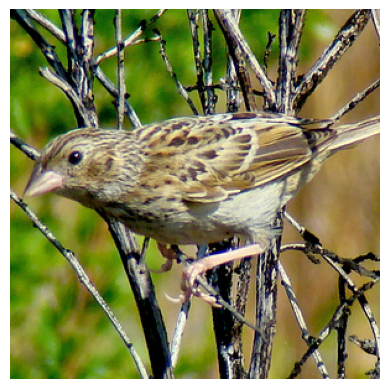

gt-class_label:		120-Grasshopper_Sparro
pred-class_label, top1:	124-Lincoln_Sparro
pred-class_label, top5:	['124-Lincoln_Sparro', '117-House_Sparro', '114-Brewer_Sparro', '195-House_Wre', '196-Marsh_Wre']
------
gt-attribute_label: [3, 4, 9, 10, 13, 15, 21, 25, 30, 31, 36, 43, 44, 49, 50, 52, 63, 69, 75, 76, 80, 82, 84, 89, 90, 95, 98, 99, 101, 110]
	3-has_bill_shape::cone
	4-has_wing_color::brown
	9-has_wing_color::buff
	10-has_upperparts_color::brown
	13-has_upperparts_color::black
	15-has_upperparts_color::buff
	21-has_underparts_color::buff
	25-has_back_color::brown
	30-has_back_color::buff
	31-has_tail_shape::notched_tail
	36-has_upper_tail_color::buff
	43-has_breast_color::white
	44-has_breast_color::buff
	49-has_throat_color::buff
	50-has_eye_color::black
	52-has_bill_length::shorter_than_head
	63-has_under_tail_color::buff
	69-has_nape_color::buff
	75-has_belly_color::buff
	76-has_wing_shape::rounded-wings
	80-has_size::very_small_(3_-_5_in)
	82-has_shape::perching-like
	84-has

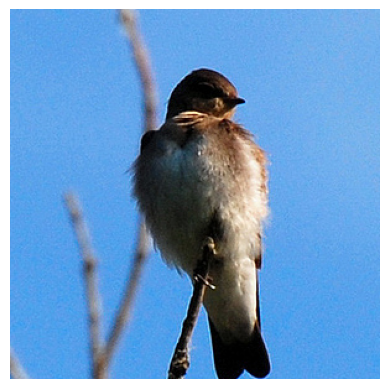

gt-class_label:		134-Bank_Swallo
pred-class_label, top1:	115-Chipping_Sparro
pred-class_label, top5:	['115-Chipping_Sparro', '114-Brewer_Sparro', '117-House_Sparro', '129-Tree_Sparro', '101-Western_Wood_Pewe']
------
gt-attribute_label: [3, 4, 7, 10, 20, 22, 25, 32, 43, 48, 50, 52, 54, 59, 74, 78, 89, 90, 93, 100]
	3-has_bill_shape::cone
	4-has_wing_color::brown
	7-has_wing_color::black
	10-has_upperparts_color::brown
	20-has_underparts_color::white
	22-has_breast_pattern::solid
	25-has_back_color::brown
	32-has_upper_tail_color::brown
	43-has_breast_color::white
	48-has_throat_color::white
	50-has_eye_color::black
	52-has_bill_length::shorter_than_head
	54-has_forehead_color::brown
	59-has_under_tail_color::brown
	74-has_belly_color::white
	78-has_size::small_(5_-_9_in)
	89-has_belly_pattern::solid
	90-has_primary_color::brown
	93-has_primary_color::black
	100-has_bill_color::black
pred-attribute_label [3, 4, 10, 20, 22, 25, 31, 32, 43, 48, 50, 52, 54, 65, 74, 76, 78, 82, 84, 89, 90, 

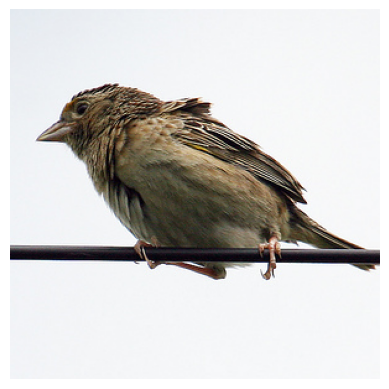

gt-class_label:		120-Grasshopper_Sparro
pred-class_label, top1:	117-House_Sparro
pred-class_label, top5:	['117-House_Sparro', '114-Brewer_Sparro', '131-White_crowned_Sparro', '34-Purple_Finc', '55-Pine_Grosbea']
------
gt-attribute_label: [3, 4, 9, 10, 13, 15, 21, 25, 30, 31, 36, 43, 44, 49, 50, 52, 63, 69, 75, 76, 80, 82, 84, 89, 90, 95, 98, 99, 101, 110]
	3-has_bill_shape::cone
	4-has_wing_color::brown
	9-has_wing_color::buff
	10-has_upperparts_color::brown
	13-has_upperparts_color::black
	15-has_upperparts_color::buff
	21-has_underparts_color::buff
	25-has_back_color::brown
	30-has_back_color::buff
	31-has_tail_shape::notched_tail
	36-has_upper_tail_color::buff
	43-has_breast_color::white
	44-has_breast_color::buff
	49-has_throat_color::buff
	50-has_eye_color::black
	52-has_bill_length::shorter_than_head
	63-has_under_tail_color::buff
	69-has_nape_color::buff
	75-has_belly_color::buff
	76-has_wing_shape::rounded-wings
	80-has_size::very_small_(3_-_5_in)
	82-has_shape::perching-like


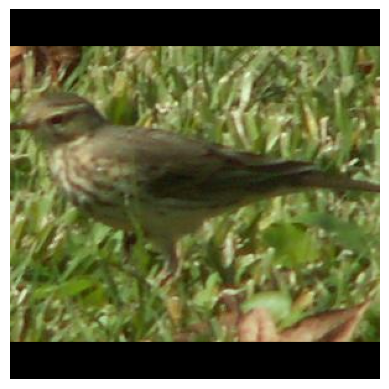

gt-class_label:		103-American_Pipi
pred-class_label, top1:	98-Ovenbir
pred-class_label, top5:	['98-Ovenbir', '173-Palm_Warble', '182-Northern_Waterthrus', '177-Swainson_Warble', '148-Brown_Thrashe']
------
gt-attribute_label: [2, 4, 9, 10, 15, 21, 23, 25, 30, 31, 32, 36, 39, 44, 49, 50, 52, 54, 59, 63, 69, 75, 76, 78, 82, 90, 95, 110]
	2-has_bill_shape::all-purpose
	4-has_wing_color::brown
	9-has_wing_color::buff
	10-has_upperparts_color::brown
	15-has_upperparts_color::buff
	21-has_underparts_color::buff
	23-has_breast_pattern::striped
	25-has_back_color::brown
	30-has_back_color::buff
	31-has_tail_shape::notched_tail
	32-has_upper_tail_color::brown
	36-has_upper_tail_color::buff
	39-has_breast_color::brown
	44-has_breast_color::buff
	49-has_throat_color::buff
	50-has_eye_color::black
	52-has_bill_length::shorter_than_head
	54-has_forehead_color::brown
	59-has_under_tail_color::brown
	63-has_under_tail_color::buff
	69-has_nape_color::buff
	75-has_belly_color::buff
	76-has_wing_shape::

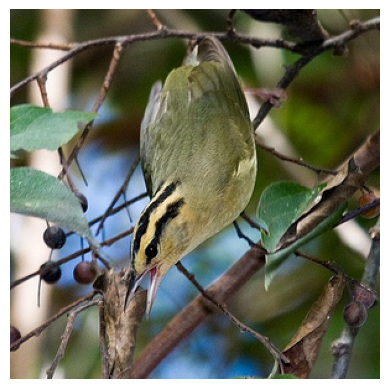

gt-class_label:		180-Worm_eating_Warble
pred-class_label, top1:	36-Acadian_Flycatche
pred-class_label, top5:	['36-Acadian_Flycatche', '42-Yellow_bellied_Flycatche', '152-Philadelphia_Vire', '177-Swainson_Warble', '175-Prairie_Warble']
------
gt-attribute_label: [2, 18, 22, 31, 33, 41, 46, 50, 52, 56, 57, 60, 66, 72, 77, 78, 82, 83, 86, 89, 92, 98, 101, 105, 106, 108]
	2-has_bill_shape::all-purpose
	18-has_underparts_color::yellow
	22-has_breast_pattern::solid
	31-has_tail_shape::notched_tail
	33-has_upper_tail_color::grey
	41-has_breast_color::yellow
	46-has_throat_color::yellow
	50-has_eye_color::black
	52-has_bill_length::shorter_than_head
	56-has_forehead_color::yellow
	57-has_forehead_color::black
	60-has_under_tail_color::grey
	66-has_nape_color::yellow
	72-has_belly_color::yellow
	77-has_wing_shape::pointed-wings
	78-has_size::small_(5_-_9_in)
	82-has_shape::perching-like
	83-has_back_pattern::solid
	86-has_tail_pattern::solid
	89-has_belly_pattern::solid
	92-has_primary_color::y

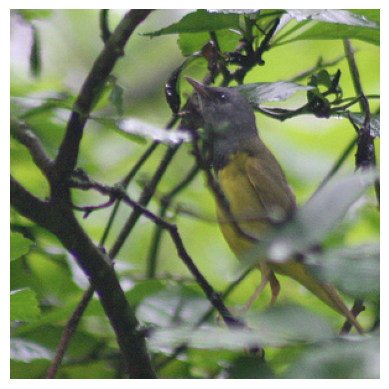

gt-class_label:		169-Mourning_Warble
pred-class_label, top1:	171-Nashville_Warble
pred-class_label, top5:	['171-Nashville_Warble', '178-Tennessee_Warble', '151-Blue_headed_Vire', '155-White_eyed_Vire', '153-Red_eyed_Vire']
------
gt-attribute_label: [2, 18, 41, 50, 52, 55, 65, 72, 78, 82, 83, 86, 89, 92, 98, 99, 104]
	2-has_bill_shape::all-purpose
	18-has_underparts_color::yellow
	41-has_breast_color::yellow
	50-has_eye_color::black
	52-has_bill_length::shorter_than_head
	55-has_forehead_color::grey
	65-has_nape_color::grey
	72-has_belly_color::yellow
	78-has_size::small_(5_-_9_in)
	82-has_shape::perching-like
	83-has_back_pattern::solid
	86-has_tail_pattern::solid
	89-has_belly_pattern::solid
	92-has_primary_color::yellow
	98-has_leg_color::buff
	99-has_bill_color::grey
	104-has_crown_color::grey
pred-attribute_label [2, 11, 12, 18, 20, 22, 26, 31, 41, 50, 52, 55, 65, 72, 76, 78, 82, 89, 92, 96, 99, 104]
	2-has_bill_shape::all-purpose
	11-has_upperparts_color::grey
	12-has_upperparts_

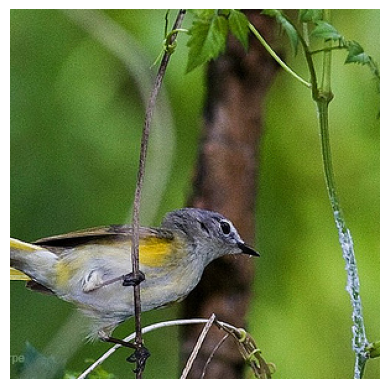

gt-class_label:		108-American_Redstar
pred-class_label, top1:	151-Blue_headed_Vire
pred-class_label, top5:	['151-Blue_headed_Vire', '38-Least_Flycatche', '159-Black_throated_Blue_Warble', '155-White_eyed_Vire', '164-Chestnut_sided_Warble']
------
gt-attribute_label: [2, 7, 13, 19, 24, 28, 31, 34, 38, 42, 47, 50, 52, 57, 61, 67, 74, 76, 78, 82, 83, 88, 93, 97, 100, 106, 111]
	2-has_bill_shape::all-purpose
	7-has_wing_color::black
	13-has_upperparts_color::black
	19-has_underparts_color::black
	24-has_breast_pattern::multi-colored
	28-has_back_color::black
	31-has_tail_shape::notched_tail
	34-has_upper_tail_color::black
	38-has_head_pattern::plain
	42-has_breast_color::black
	47-has_throat_color::black
	50-has_eye_color::black
	52-has_bill_length::shorter_than_head
	57-has_forehead_color::black
	61-has_under_tail_color::black
	67-has_nape_color::black
	74-has_belly_color::white
	76-has_wing_shape::rounded-wings
	78-has_size::small_(5_-_9_in)
	82-has_shape::perching-like
	83-has_back_patt

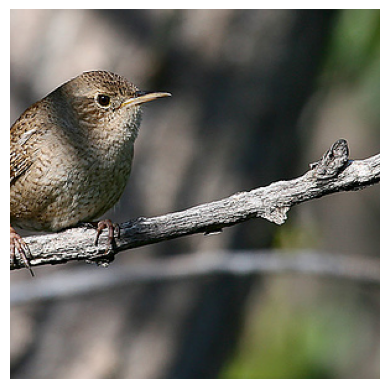

gt-class_label:		195-House_Wre
pred-class_label, top1:	198-Winter_Wre
pred-class_label, top5:	['198-Winter_Wre', '197-Rock_Wre', '192-Bewick_Wre', '196-Marsh_Wre', '51-Pied_billed_Greb']
------
gt-attribute_label: [2, 4, 9, 10, 15, 21, 22, 25, 30, 32, 36, 44, 49, 50, 51, 54, 59, 63, 64, 69, 75, 82, 83, 87, 89, 90, 98, 99, 103, 110]
	2-has_bill_shape::all-purpose
	4-has_wing_color::brown
	9-has_wing_color::buff
	10-has_upperparts_color::brown
	15-has_upperparts_color::buff
	21-has_underparts_color::buff
	22-has_breast_pattern::solid
	25-has_back_color::brown
	30-has_back_color::buff
	32-has_upper_tail_color::brown
	36-has_upper_tail_color::buff
	44-has_breast_color::buff
	49-has_throat_color::buff
	50-has_eye_color::black
	51-has_bill_length::about_the_same_as_head
	54-has_forehead_color::brown
	59-has_under_tail_color::brown
	63-has_under_tail_color::buff
	64-has_nape_color::brown
	69-has_nape_color::buff
	75-has_belly_color::buff
	82-has_shape::perching-like
	83-has_back_pattern::soli

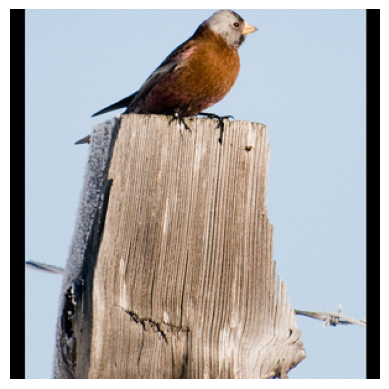

gt-class_label:		33-Gray_crowned_Rosy_Finc
pred-class_label, top1:	135-Barn_Swallo
pred-class_label, top5:	['135-Barn_Swallo', '96-Orchard_Oriol', '79-Green_Kingfishe', '138-Scarlet_Tanage', '10-Rusty_Blackbir']
------
gt-attribute_label: [3, 9, 10, 11, 13, 16, 21, 25, 30, 31, 33, 39, 44, 50, 52, 55, 57, 60, 64, 70, 75, 76, 78, 82, 84, 87, 90, 91, 93, 97, 101, 104, 110]
	3-has_bill_shape::cone
	9-has_wing_color::buff
	10-has_upperparts_color::brown
	11-has_upperparts_color::grey
	13-has_upperparts_color::black
	16-has_underparts_color::brown
	21-has_underparts_color::buff
	25-has_back_color::brown
	30-has_back_color::buff
	31-has_tail_shape::notched_tail
	33-has_upper_tail_color::grey
	39-has_breast_color::brown
	44-has_breast_color::buff
	50-has_eye_color::black
	52-has_bill_length::shorter_than_head
	55-has_forehead_color::grey
	57-has_forehead_color::black
	60-has_under_tail_color::grey
	64-has_nape_color::brown
	70-has_belly_color::brown
	75-has_belly_color::buff
	76-has_wing_shape

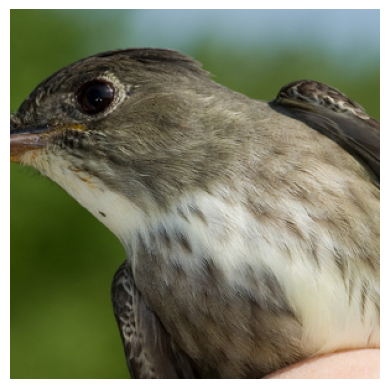

gt-class_label:		39-Olive_sided_Flycatche
pred-class_label, top1:	38-Least_Flycatche
pred-class_label, top5:	['38-Least_Flycatche', '102-Sayorni', '170-Myrtle_Warble', '41-Vermilion_Flycatche', '173-Palm_Warble']
------
gt-attribute_label: [2, 5, 11, 17, 26, 31, 33, 38, 40, 50, 52, 55, 60, 71, 78, 82, 86, 91, 97, 100, 104, 111]
	2-has_bill_shape::all-purpose
	5-has_wing_color::grey
	11-has_upperparts_color::grey
	17-has_underparts_color::grey
	26-has_back_color::grey
	31-has_tail_shape::notched_tail
	33-has_upper_tail_color::grey
	38-has_head_pattern::plain
	40-has_breast_color::grey
	50-has_eye_color::black
	52-has_bill_length::shorter_than_head
	55-has_forehead_color::grey
	60-has_under_tail_color::grey
	71-has_belly_color::grey
	78-has_size::small_(5_-_9_in)
	82-has_shape::perching-like
	86-has_tail_pattern::solid
	91-has_primary_color::grey
	97-has_leg_color::black
	100-has_bill_color::black
	104-has_crown_color::grey
	111-has_wing_pattern::multi-colored
pred-attribute_label [2, 20

In [126]:

repo_dir = '..\\ConceptBottleneck\\'

for i in sample_wrong_ids:
    #gt
    id_ = test_image[i]['id']
    img_path = test_image[i]['img_path']
    class_label = test_image[i]['class_label']
    attribute_label = test_image[i]['attribute_label']
    attribute_certainty = test_image[i]['attribute_certainty']
    
    img_path = repo_dir+img_path.split('CUB_supervision/datasets/')[-1]
    print('------')
    #display(Image(filename=img_path))
    show(test_images_loader[i])
    
    print('gt-class_label:\t\t{}-{}'.format(class_label,classes[class_label]))
    pred_label = np.argmax(pred_class_logits[i])
    print('pred-class_label, top1:\t{}-{}'.format(pred_label,classes[pred_label]))
    topk_pred_labels = list(pred_topk_class_outputs[i])
    topk_pred_txt = [classes[each] for each in topk_pred_labels]
    print('pred-class_label, top5:\t{}'.format(['{}-{}'.format(topk_pred_labels[q],topk_pred_txt[q]) for q in range(5)]))
    
    print('------')
    gt_attr = list([each for each in range(112) if attribute_label[each] ==1])
    print('gt-attribute_label:',gt_attr)
    for j in range(len(attribute_label)):
        if attribute_label[j] == 1:
            print('\t{}-{}'.format(j,attributes[j]))
            
    threshold = 0.5
    pred_attr_thre = list(np.where(pred_attr_outputs_sigmoid[i]>threshold)[0])
    print('pred-attribute_label',pred_attr_thre)
    for each in pred_attr_thre:
        print('\t{}-{}'.format(each,attributes[each]))
        
    print('------')
    print('Euclidean distance between concept attributes: {:.2f}'.format(np.linalg.norm(attribute_label-pred_attr_outputs_sigmoid[i])))
    